# Recommender System RL Tutorial

**추천 시스템** (recommender system)은 유저의 선호도 (preference)에 맞는 아이템을 제공하는 시스템입니다. 이는 유저-아이템 상호작용 히스토리를 고려해 이루어지는데, 추천 시스템이 유저에게 아이템을 제공하면 유저는 이에 대해 **피드백** (스킵, 클릭, 구매 등)을 제공합니다. 유튜브, 넷플릭스 등 수 많은 어플리케이션에서 이러한 추천 시스템을 도입하고 있습니다.

추천 시스템은 머신 러닝 (machine learning)을 통해 구축할 수 있습니다. 지도학습 (supervised learning)과 같은 기존 방법들은 대체적으로 **유저와 추천 모델 사이의 상호작용을 무시**해 불만족스러운 결과를 내놓습니다. 일반적으로, 추천 시스템은 인터렉티브한 프로세스로 **연속적인 의사 결정 문제** (sequential decision making problem)입니다. 따라서 **강화학습** (reinforcement learning)을 사용하여 최적화할 수 있습니다.

이 튜토리얼에서는 강화학습으로 어떻게 추천 시스템을 구축하는 지에 대해 알아볼 것이며, 관련 방법들에 대한 intution을 얻으려 합니다.

## Problem: Recommend Items based on Sweetness

초콜릿과 케일 (채소)이 여러 개 있습니다. 우리는 초콜릿과 케일 중 어떤 것을 추천해야 유저가 만족할까를 고민하고 있습니다. 초콜릿은 단 맛이고, 케일은 쓴 맛이기 때문에 초콜릿과 케일을 달콤함 (sweetness)로 나타낼 수 있습니다. 여기서는 단순함을 위해 달콤함만 고려합시다. 유저들은 대체적으로 쓴 음식보다는 달콤한 음식을 선호할 것입니다. 우리가 생각해볼 수 있는 방법은 달콤한 음식만 추천하는 것입니다. 그러나 달콤한 음식만 추천하다보면 유저들은 점점 만족스러워하지 않을 것입니다. 왜냐하면 자신의 건강 역시 생각하기 떄문이죠. 따라서 유저들은 달콤한 음식보다는 건강에 좋은 달콤하지 않은 음식을 점점 더 선호하게 될 가능성이 있습니다. 그러나 대체적으로 달콤한 음식을 선호하는 유저들이 지속적으로 쓴 음식만 추천 받는다면 역시 불만족스럽겠죠. 이러한 요소들을 종합하면 우리의 가설은 다음과 같습니다: **유저들은 대체적으로 달콤한 음식을 선호하지만, 시간이 지나면서 점점 달콤한 음식의 선호도가 내려가기 때문에 중간 중간 달콥하지 않은 음식도 추천 받길 원한다.**

Fig 1. 유저의 선호도 변화. (Image source: ACM RecSys 2022 Tutorial):

![](img/user_choice_model.png)

## Definition

추천 시스템은 앞서 언급했듯이 인터렉티브한 프로세스로 연속적인 의사 결정 문제입니다. 그리고 이는 강화학습을 통해 최적화 할 수 있습니다. 학습을 수행하기 위해서는 당연히 우리의 **목적** (objective)을 설정해야 합니다.

Objective: Maximize user's engagement.

여기서 engagment란 단어가 다소 모호할 수 있습니다. engagement란 추천된 아이템에 대한 상호작용이나 유저의 행동으로, **유저의 흥미나 관심을 얼마나 효과적으로 끌고 있는지를 나타내는 측정값**입니다. 예를 들면, 추천된 동영상을 시청한 시간 정도 입니다. 여기서는 유저의 달콤한 아이템에 대한 선호도와 장기적으로는 좀 더 건강한 옵션들을 고려하는 정도 사이에서의 어떤 함수로, 만족도를 나타낸다고 생각하시면 됩니다 [TODO, 설명이 잘못됐을 수도 있으니 점검]. 

그 다음 해야할 것은 **agent**와 **environment**의 구분입니다. agent는 추천 모델로 유저에게 추천 리스트를 제공하는 역할을 합니다. environment는 agent에게 유저와 아이템으로부터 관찰된 정보 observation을 제공하고, 유저 피드백을 바탕으로 reward를 제공하는 역할을 합니다.

### Markov Decision Process

**markov decision process** (MDP)는 연속적인 의사 결정 모델로 tuple $\mathcal{M} = (\mathcal{S}, \mathcal{A}, p, r, \gamma)$로 정의됩니다:

* $\mathcal{S}$ is a set of states called the state space,
* $\mathcal{A}$ is a set of actions called the action space,
* $p(s_{t+1} \vert s_t, a_t)$ is a state transition probability function,
* $r(s_t, a_t)$ is a reward function,
* $\gamma \in [0, 1]$ is a scalar discount factor.

time step $t$일 때, agent는 state $S_t$에서 action $A_t$를 선택합니다. 그러면 새로운 state $S_{t+1}$으로의 transition이 발생하고, environment로부터 reward $R_{t+1}$를 제공받습니다. 이러한 과정이 여러 time step에 걸쳐 수행됩니다. 아래는 MDP를 나타내는 그림입니다.

Fig 2. Markov Decision Process. (Image source: Sutton & Barto (2018).)

![](img/markov_decision_process.png)

그러나 agent가 environment의 state에 대한 모든 정보를 관찰하기는 어렵습니다. 게임으로 예를 들면, agent가 현재 time step에서의 게임에 대한 모든 정보가 아닌, 화면에 출력되는 이미지 1프레임만을 관찰하는 경우를 들 수 있습니다. 이처럼 state의 일부분만을 관찰하는 MDP를 partially observable markov decision process (POMDP)라고 하며, agent는 environment로부터 state $S_t$가 아닌 **observation** $O_t$를 제공받습니다. 여기서는 단순성을 위해 POMDP에 대한 자세한 설명은 생략하며, state 대신 observation으로 바뀌었다고만 받아들이시면 됩니다.

MDP에서 매 time step 마다 reward를 획득합니다. 각 time step에서 선택한 action은 future reward에 영향을 미칩니다. 따라서 즉각적인 reward만 고려하는 것이 아닌, future reward의 총합인 cumulative reward를 maximize하도록 최적화하는 것이 자연스럽습니다. 현재 time step $t$에서 future reward에 얼마나 큰 비중을 둘 것이냐를 결정하는 요소가 바로 discount factor $\gamma$입니다. discount factor가 0이면 즉각적인 reward만을 고려하고, 1이면 future reward를 모두 동등하게 고려합니다. discount factor가 포함된 cumulative reward를 discounted cumulative reward라고 하며 이를 **return**이라고 부릅니다. return의 수학적 정의는 다음과 같습니다:

$$
G_t \doteq R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \cdots = \sum_{k=t+1}^T \gamma^{k-t-1}R_k
$$

여기서 $T$는 terminal time step으로 episode가 종료되는 시점입니다.

일반적으로, 추천 모델은 **유저 feature와 다큐먼트 feature에 대한 관찰**을 기반으로 작동합니다. 유저 feature는 성별, 나이 등 유저와 관련된 유의미한 feature들로 구성됩니다. **다큐먼트** (document)는 추천될 후보 아이템 set으로, 후보 아이템을 선정하는 특정 알고리즘에 의해 sampling되거나 고정된 아이템 set으로 구성될 수 있습니다. 다큐먼트 내 아이템들은 모두 유의미한 feature를 가지고 있습니다. 다큐먼트가 $d$개의 아이템으로 구성된다고 할 때, 추천 모델은 $d$개의 아이템 중 $k$개의 아이템을 추천합니다. 이 때 추천된 $k$개의 아이템 set을 **slate**라고 부릅니다. 

이제 우리의 문제를 MDP로 formulate 합시다. 

* observation: sweetness of $d$ items
* action: $k$ items $\in$ the document
* reward: represent engagement

우리는 $d = 20$, $k = 1$을 사용할 것입니다. 여기서는 단순함을 위해 유저 feature는 고려하지 않습니다. 그러나 유저 feature는 실제로 매우 중요합니다. 예를 들어 성별을 고려 시, 상대적으로 여성이 남성보다 달콤한 음식을 선호하므로 이는 추천 시 중요한 feature가 될 수 있습니다.

## RecSim

우리는 [Google RecSim](https://github.com/google-research/recsim) environment를 사용합니다. RecSim은 유저와의 연속적인 상호작용을 지원하는 추천 시스템에 대한 시뮬레이션 environment로, youtube 추천 알고리즘을 위해 개발되었습니다. 아래는 RecSim 아키텍쳐를 나타내는 그림으로 지금까지 설명한 내용을 한번에 보여주고 있습니다.

Fig 3. Control flow in the RecSim architecture. (Image source: Ie, Eugene, et al (2019).)

![](img/rec-sim-architecture.jpeg)

RecSim 환경을 생성하고 실행해봅시다. RecSim은 [OpenAI Gym](https://github.com/openai/gym) 표준 API를 따릅니다.

In [1]:
from recsim_env import make_recsim_env
from pprint import pprint

env = make_recsim_env()
obs, _ = env.reset()
pprint(obs)

2023-09-13 03:32:58.779785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-13 03:32:59.294360: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/devslem/miniconda3/envs/recsys-tutorial/lib/python3.10/site-packages/gin/tf/__init__.py:48: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <
2023-09-13 03:33:00,346	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2023-09-13 03:33:01,371	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for 

OrderedDict([('user', array([], dtype=float32)),
             ('doc',
              {'0': array([0.99572366], dtype=float32),
               '1': array([0.15983172], dtype=float32),
               '10': array([0.8529111], dtype=float32),
               '11': array([0.15484674], dtype=float32),
               '12': array([0.89123005], dtype=float32),
               '13': array([0.11368679], dtype=float32),
               '14': array([0.80375797], dtype=float32),
               '15': array([0.1235271], dtype=float32),
               '16': array([0.92241913], dtype=float32),
               '17': array([0.1233868], dtype=float32),
               '18': array([0.9887496], dtype=float32),
               '19': array([0.13636406], dtype=float32),
               '2': array([0.8922959], dtype=float32),
               '3': array([0.15610583], dtype=float32),
               '4': array([0.8236549], dtype=float32),
               '5': array([0.12798421], dtype=float32),
               '6': array([0.8

observation의 각 key는 다음과 같습니다:

* `user`: 관찰 가능한 유저 feature가 없기 때문에 비어있습니다.
* `doc`: 20개의 아이템을 가지고 있으며 각 아이템 feature는 달콤함을 나타냅니다.
* `response`: 바로 직전 상호작용에서의 `click` 및 `engagement`에 대한 단일 기록을 포함합니다.
* `time`: session 내에서의 정규화된 time step으로 `-0.5`는 상호작용의 시작, `+0.5`는 상호작용의 끝을 나타냅니다.

이제 reward가 어떤 경향을 가지는지 관찰해봅시다. 가장 달콤한 아이템만 추천했을 때 reward가 시간에 따라 어떻게 변하는지 확인해봅시다. 이는 우리의 가설이 맞는지 확인해볼 수 있는 좋은 시도입니다.

In [2]:
import numpy as np

def inference_env(policy, n_episodes):
    rewards = np.zeros((n_episodes, 10)) # maximum time step = 9
    for episode in range(n_episodes):
        obs, _ = env.reset()
        terminated = False
        time_step = 0
        while not terminated:
            # take action and observe
            action = policy(obs)
            next_obs, reward, terminated, truncated, info = env.step(action)
            terminated |= truncated
            
            rewards[episode, time_step] = reward
            obs = next_obs
            time_step += 1
            
    return rewards

In [3]:
sweetest_policy = lambda obs: int(max(obs["doc"], key=lambda x: obs['doc'][x])) # sweetest item
sweetest_policy_rewards = inference_env(sweetest_policy, n_episodes=10)

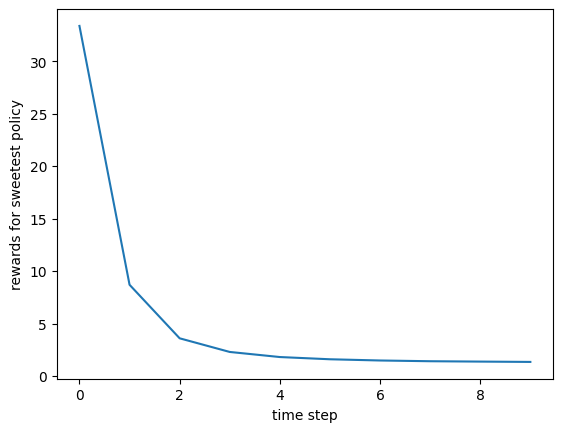

In [4]:
import matplotlib.pyplot as plt

rewards_per_time_step = np.mean(sweetest_policy_rewards, axis=0)
plt.plot(rewards_per_time_step)
plt.xlabel("time step")
plt.ylabel("rewards for sweetest policy")
plt.show()

우리는 이 시뮬레이션을 통해 다음과 같은 사실을 확인할 수 있습니다:

1. 초기에 가장 달콤한 아이템을 추천했을 때의 즉각적인 reward는 높다.
2. 가장 달콤한 아이템만을 추천할 경우 유저의 만족도는 급격히 떨어진다.

유저에게 아이템을 랜덤하게 추천하면 어떻게 될까요? 동일하게 시뮬레이션 해봅시다.

In [5]:
random_policy = lambda obs: np.random.randint(len(obs["doc"].keys())) # random item
random_policy_rewards = inference_env(random_policy, n_episodes=10)

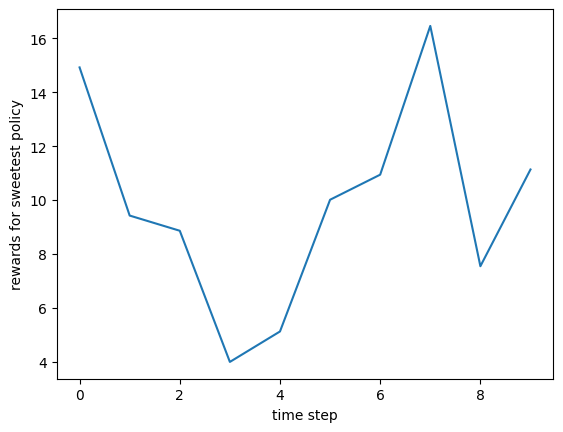

In [6]:
rewards_per_time_step = np.mean(random_policy_rewards, axis=0)
plt.plot(rewards_per_time_step)
plt.xlabel("time step")
plt.ylabel("rewards for sweetest policy")
plt.show()

이를 통해 time step이 커질 수록, 달콤한 아이템만 추천하는 것이 아니라 달콤하지 않은 아이템도 추천하는게 더 좋은 결과를 얻을 수 있다는 것을 알게 되었습니다. 이제 두 베이스라인의 cumulative reward를 비교해봅시다.

In [7]:
sweetest_policy_cumulative_rewards = np.sum(sweetest_policy_rewards, axis=1)
random_policy_cumulative_rewards = np.sum(random_policy_rewards, axis=1)

print(f"Sweetest policy cumulative reward: {np.mean(sweetest_policy_cumulative_rewards):.2f}+/-{np.std(sweetest_policy_cumulative_rewards):.2f}")
print(f"Random policy cumulative reward: {np.mean(random_policy_cumulative_rewards):.2f}+/-{np.std(random_policy_cumulative_rewards):.2f}")

Sweetest policy cumulative reward: 56.93+/-1.44
Random policy cumulative reward: 98.41+/-24.32


유저들이 대체적으로 달콤한 아이템을 선호한다고 해서 달콤한 아이템만 추천할 경우 오히려 만족도가 떨어진다는 점을 확연히 알 수 있습니다. 강화학습은 이러한 문제를 효과적으로 해결할 수 있는 좋은 방법입니다.

## Reinfocement Learning

강화학습은 연속적인 의사 결정 문제를 최적화하는 방법입니다. agent는 policy $\pi(a \vert s)$에 의해 action을 선택하며, discounted expected return $\mathbb{E}[G_t]$을 maximize하도록 policy $\pi$를 최적화합니다. 이 튜토리얼에서는 [Ray RLlib](https://docs.ray.io/en/latest/rllib/index.html)에서 제공하는 DQN 알고리즘을 사용합니다. DQN은 Q-learning과 딥러닝을 결합한 방법입니다. 여기서는 DQN에 대한 자세한 설명은 생략하겠습니다.

### Short-term RL

discount factor는 학습에 매우 큰 영향을 미칩니다. 따라서, discount factor에 관한 이해가 필요합니다. 먼저, 즉각적인 reward만을 고려하는 $\gamma = 0$인 세팅에서 실험을 해보겠습니다. 이는 multi-armed bandit (MAB)과 유사한 세팅입니다. MAB 알고리즘 역시 추천 시스템에 많이 사용되었던 알고리즘입니다. 그러나, MAB는 즉각적인 reward만을 고려하기 때문에 long-term한 연속적인 의사 결정 문제에는 취약합니다. 따라서, $\gamma = 0$인 short-term RL을 실험해보면 MAB의 문제점을 파악할 수 있을 겁니다.

shor-term RL로 학습하는 코드를 작성해 봅시다. Ray RLlib를 사용하며 매우 간편하게 학습을 시킬 수 있습니다.

In [ ]:
from ray.rllib.algorithms.dqn import DQN, DQNConfig
from ray import tune, air
import ray

ray.init(log_to_driver=False)
tune.register_env("modified-lts", lambda config: make_recsim_env())

# set up the environment config
config = DQNConfig().environment("modified-lts") \
                    .framework("torch") \
                    .resources(num_gpus=1) \
                    .training(gamma=0.0)
                    
tuner = tune.Tuner(
    DQN,
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        local_dir="./results/short_term_rl",
        stop={"training_iteration": 100},
    )
)

result_short_term_rl = tuner.fit()

In [9]:
def plot_baseline_cumulative_rewards():
    plt.axhline(np.mean(random_policy_cumulative_rewards), color="red", linestyle='--', label="random policy")
    plt.axhline(np.mean(sweetest_policy_cumulative_rewards), color="blue", linestyle='--', label="sweetest policy")
    plt.legend()
    plt.xlabel("training iteration")
    plt.ylabel("cumulative reward")
    plt.show()

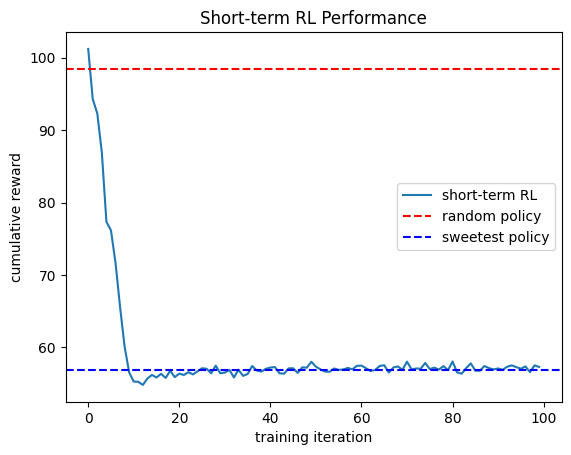

In [10]:
import pandas as pd

result_short_term_rl_df = pd.read_csv(f"{result_short_term_rl[0].path}/progress.csv")
plt.plot(result_short_term_rl_df['episode_reward_mean'], label="short-term RL")
plt.title("Short-term RL Performance")
plot_baseline_cumulative_rewards()

위 그래프를 보면 shor-term RL은 학습을 수행할 수록 sweetest policy와 유사해집니다. 가장 달콤한 아이템을 추천하는 것이 즉각적인 reward를 획득하기에 가장 쉽기 때문입니다. 이를 통해 MAB 알고리즘은 연속적으로 아이템을 추천해야하는 시스템에 취약함을 알 수 있습니다.

### Long-term RL

이번에는 discount factor $\gamma = 0.99$로 세팅해봅시다. 일반적으로, 강화학습에서 discount factor를 0.95 ~ 1 사이의 값으로 설정합니다.

In [ ]:
# set up the environment config
config = DQNConfig().environment("modified-lts") \
                    .framework("torch") \
                    .resources(num_gpus=1) \
                    .training(gamma=0.99)
                    
tuner = tune.Tuner(
    DQN,
    param_space=config.to_dict(),
    run_config=air.RunConfig(
        local_dir="./results/long_term_rl",
        stop={"training_iteration": 100},
    )
)

result_long_term_rl = tuner.fit()

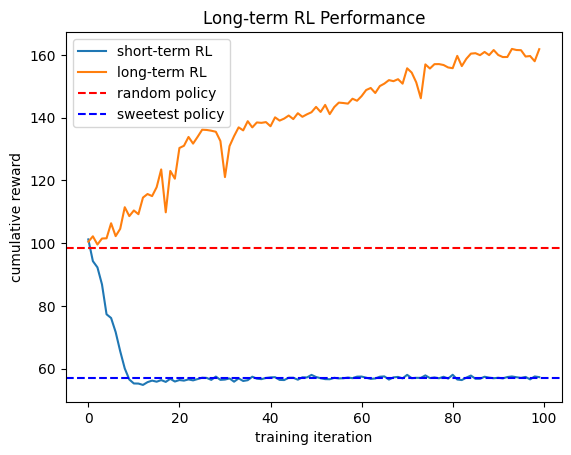

In [12]:
result_long_term_rl_df = pd.read_csv(f"{result_long_term_rl[0].path}/progress.csv")

plt.plot(result_short_term_rl_df['episode_reward_mean'], label="short-term RL")
plt.plot(result_long_term_rl_df['episode_reward_mean'], label="long-term RL")
plt.title("Long-term RL Performance")
plot_baseline_cumulative_rewards()

학습 결과 RL이 추천 시스템에 효과적인 방법임을 알 수 있습니다.

### Offline RL

[TODO]

## References

[1] Anyscale "[ACM RecSys 2022 Tutorial](https://github.com/anyscale/academy/tree/main/ray-rllib/acm_recsys_tutorial_2022)"   (Github).  
[2] Ie, Eugene, et al. "[Recsim: A configurable simulation platform for recommender systems.](https://arxiv.org/abs/1909.04847)  " arXiv preprint arXiv:1909.04847 (2019).  
[3] Lin, Yuanguo, et al. "[A survey on reinforcement learning for recommender systems.](https://ieeexplore.ieee.org/abstract/document/10144689?casa_token=bzipVczGG2wAAAAA:gkdWb-kk6v_bBlzY7Y3JLzwtsuWBrkw72iJE9Nm-r0uCB9ZDi_FCA-kwxbVTYlQjuOEi1BsW)" IEEE Transactions on Neural Networks and Learning Systems (2023).  
[4] Sutton, Richard S., and Andrew G. Barto. Reinforcement learning: An introduction. MIT press, 2018.